In [1]:
###fnc definitions, import data
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as rnd
# from jax.experimental.host_callback import id_print
# from jax.experimental.host_callback import call
import optax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
# matplotlib.use('Agg')
from drawnow import drawnow
import numpy as np
import csv
import pickle
from pathlib import Path
from datetime import datetime
import re
import os
import sys
# from os.path import dirname, abspath
import scipy

def load_(str_):
    path_ = os.path.dirname(os.getcwd()) + '/pkl/' # Path(__file__).resolve().parents[1]
    with open(path_+str_,'rb') as file_:
        # param = pickle.load(file_)
        param_ = jnp.load(file_,allow_pickle=True)
    return param_

def geod_dist(dots,pos):### calculate geodesic
    pos_ = pos #(pos+jnp.pi)%(2*jnp.pi)-jnp.pi
    th1 = jnp.minimum(jnp.abs(pos_[1]-dots[:,1]),2*jnp.pi-jnp.abs(pos_[1]-dots[:,1]))
    th2 = jnp.minimum(jnp.abs(pos_[0]-dots[:,0]),2*jnp.pi-jnp.abs(pos_[0]-dots[:,0]))
    return jnp.sqrt(th1**2+th2**2)

def geod_dist_dot(dot,pos):### calculate geodesic for single dot
    th1 = jnp.minimum(jnp.abs(pos[1]-dot[1]),2*jnp.pi-jnp.abs(pos[1]-dot[1]))
    th2 = jnp.minimum(jnp.abs(pos[0]-dot[0]),2*jnp.pi-jnp.abs(pos[0]-dot[0]))
    return jnp.sqrt(th1**2+th2**2)

geod_dist_dot_vmap = jax.vmap(geod_dist_dot,in_axes=(None,0),out_axes=0)

file_ = 'v9_all_30_04-2137.pkl' # 'v9_all_28_04-1607.pkl','v9_all_27_04-1754.pkl','v9_all_25_04-1610.pkl'
vals_train,vals_test,theta_test = load_(file_) # 
(R_tot,R_obj,R_env,R_dot,R_sel),(sd_tot,sd_obj,sd_env,sd_dot,sd_sel) = vals_train
(pos_arr,switch_arr,R_all) = vals_test
(R_test,R_r,R_g,R_b) = R_all # [TESTS,VMAPS,IT+1]

TESTS = R_test.shape[0]
VMAPS = R_test.shape[1]
IT = R_test.shape[2]
print('TESTS,VMAPS,IT:',TESTS,VMAPS,IT)
print(pos_arr.shape)

TESTS,VMAPS,IT: 10 1000 161
(10, 1000, 161, 2)


/tmp/ipykernel_23856/4170674208.py:4: RuntimeWarning: invalid value encountered in multiply
  sel_dot = np.nan*np.empty((TESTS,VMAPS,2))


[8691 8307 7831 7104 6008 4360 2602 1270  474  141   30    6    2    1]
% found =  [8.691e+01 8.307e+01 7.831e+01 7.104e+01 6.008e+01 4.360e+01 2.602e+01
 1.270e+01 4.740e+00 1.410e+00 3.000e-01 6.000e-02 2.000e-02 1.000e-02]


/tmp/ipykernel_23856/4170674208.py:42: RuntimeWarning: Mean of empty slice
  avg_intervals = np.nanmean(intervals_true,axis=(0,1))##np.nanmean(intervals,axis=(0,1))
/tmp/ipykernel_23856/4170674208.py:44: RuntimeWarning: Mean of empty slice
  sd_intervals = np.nanmean(intervals_true,axis=(0,1))##np.nanstd(intervals,axis=(0,1))


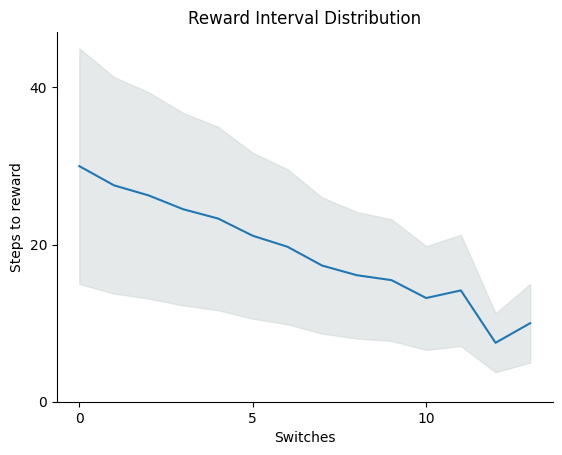

In [22]:
#find reward intervals
threshold = 0.5

sel_dot = np.nan*np.empty((TESTS,VMAPS,2))
intervals = np.nan*np.empty((TESTS,VMAPS,IT))
intervals_true = np.nan*np.empty((TESTS,VMAPS,IT))
dis_switch = np.nan*np.empty((TESTS,VMAPS,IT))
dis_all = np.nan*np.empty((TESTS,VMAPS,IT))
switch_locs_arr = np.nan*np.empty((TESTS,VMAPS,IT))

for t in range(TESTS):
    for v in range(VMAPS):
        ## unpack
        dots = theta_test["ENV"]["DOTS"][t,:,:,v] # [3,2]
        sel = theta_test["ENV"]["SELECT"][t,v,:] # [3]
        sel_dot = np.dot(sel,dots) # [t,v,:], [2]
        ## find locations of agent after each switch
        switch_locs = np.where(switch_arr[t,v,:]==1)[0]
        switch_locs = np.insert(switch_locs,0,0)
        switch_locs_arr[t,v,:len(switch_locs)] = switch_locs### true switch locs
        pos_locs = pos_arr[t,v,switch_locs,:] # [switch_locs,2], switches+initial loc (ignore last)
        ## place geod dis in dis_
        dis_switch[t,v,:pos_locs.shape[0]-1] = geod_dist_dot_vmap(sel_dot,pos_locs[:-1]) # [pos_locs,] distance to rewarded dot at each teleport
        dis_all[t,v,:] = geod_dist_dot_vmap(sel_dot,pos_arr[t,v,:]) # [IT,] distance to all dots at each step
        ## compare dis_[t,v,:] (distance to dot after teleport) to intervals[t,v,:] (steps to reward after teleport)
        obj_peaks = scipy.signal.find_peaks((-R_test[t,v,:]),height=threshold)
        if obj_peaks[0].size == 0:
            continue
        else:
            intervals[t,v,:len(obj_peaks[0])-1] = np.diff(obj_peaks[0])
        intervals_true[t,v,:len(switch_locs)-1] = np.diff(switch_locs)
        # r_peaks = scipy.signal.find_peaks((-R_r[t,v,:]),height=threshold)
        # g_peaks = scipy.signal.find_peaks((-R_g[t,v,:]),height=threshold)
        # b_peaks = scipy.signal.find_peaks((-R_b[t,v,:]),height=threshold)

# find nonzero elements of 'counts':
counts = np.count_nonzero(~np.isnan(intervals_true),axis=(0,1))
counts = counts[np.nonzero(counts)]
print(counts)
print(r'% found = ',str((100*counts)/(TESTS*VMAPS)))

avg_intervals = np.nanmean(intervals_true,axis=(0,1))##np.nanmean(intervals,axis=(0,1))
avg_intervals = avg_intervals[~np.isnan(avg_intervals)]
sd_intervals = np.nanmean(intervals_true,axis=(0,1))##np.nanstd(intervals,axis=(0,1))
sd_intervals = sd_intervals[~np.isnan(sd_intervals)]

# plot avg_intervals (avg steps to reward after teleport) vs switch number
fig,ax = plt.subplots()
ax.plot(np.arange(len(avg_intervals)),avg_intervals)
ax.fill_between(np.arange(len(avg_intervals)),avg_intervals-sd_intervals/2,avg_intervals+sd_intervals/2,alpha=0.5,color='#cdd4d4')
ax.set_xticks([0,5,10])
ax.set_xticklabels(['0','5','10'])
ax.set_xlabel('Switches')
ax.set_yticks([0,20,40])
ax.set_yticklabels(['0','20','40'])
ax.set_ylabel('Steps to reward')
ax.set_title('Reward Interval Distribution')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

path__ = os.path.dirname(os.getcwd()) + '/figs_analysis/'
dt = datetime.now().strftime("%d_%m-%H%M")
plt.savefig(path__ + 'reward_intervals_' + file_ + '.png')
# # plt.show()

In [23]:
print(intervals_true[0,:,:],intervals_true.shape)
print(dis_switch[0,:,:],dis_switch.shape)
print(switch_locs_arr[0,:,:],switch_locs_arr.shape)
print(dis_all[0,:,:],dis_all.shape)


[[ 40.  32.  15. ...  nan  nan  nan]
 [ 10. 136.  nan ...  nan  nan  nan]
 [105.  55.  nan ...  nan  nan  nan]
 ...
 [ 54.   7.  25. ...  nan  nan  nan]
 [ 16.  50.  24. ...  nan  nan  nan]
 [ nan  nan  nan ...  nan  nan  nan]] (10, 1000, 161)
[[2.44984818 0.50540036 3.1613574  ...        nan        nan        nan]
 [1.46753836 0.71849769        nan ...        nan        nan        nan]
 [1.16165876 2.6199851         nan ...        nan        nan        nan]
 ...
 [2.76916862 1.97486258 2.51036191 ...        nan        nan        nan]
 [3.81936145 3.59603477 2.80526042 ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]] (10, 1000, 161)
[[  0.  40.  72. ...  nan  nan  nan]
 [  0.  10. 146. ...  nan  nan  nan]
 [  0. 105. 160. ...  nan  nan  nan]
 ...
 [  0.  54.  61. ...  nan  nan  nan]
 [  0.  16.  66. ...  nan  nan  nan]
 [  0.  nan  nan ...  nan  nan  nan]] (10, 1000, 161)
[[2.44984818 2.39148307 2.40021276 ... 1.64834857 1.

In [ ]:
### plot based on find_peaks for comparison:
# avg_intervals = np.nanmean(intervals,axis=(0,1))##np.nanmean(intervals,axis=(0,1))
# avg_intervals = avg_intervals[~np.isnan(avg_intervals)]
# sd_intervals = np.nanmean(intervals,axis=(0,1))##np.nanstd(intervals,axis=(0,1))
# sd_intervals = sd_intervals[~np.isnan(sd_intervals)]

# fig,ax = plt.subplots()
# ax.plot(np.arange(len(avg_intervals)),avg_intervals)
# ax.fill_between(np.arange(len(avg_intervals)),avg_intervals-sd_intervals/2,avg_intervals+sd_intervals/2,alpha=0.5,color='#cdd4d4')
# # ax.errorbar(np.arange(len(avg_intervals)),avg_intervals,yerr=sd_intervals/2,c='k')
# ax.set_xticks([0,5,10])
# ax.set_xticklabels(['0','5','10'])
# ax.set_xlabel('Switches')
# ax.set_yticks([10,20,30,40])
# ax.set_yticklabels(['10','20','30','40'])
# ax.set_ylabel('Steps to reward')
# ax.set_title('Reward Interval Distribution')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# path__ = os.path.dirname(os.getcwd()) + '/figs_analysis/'
# dt = datetime.now().strftime("%d_%m-%H%M")
# plt.savefig(path__ + 'reward_intervals_' + file_ + '.png')
# # plt.show()

% found = [8.691e+01 8.307e+01 7.831e+01 7.104e+01 6.008e+01 4.360e+01 2.602e+01
 1.270e+01 4.740e+00 1.410e+00 3.000e-01 6.000e-02 2.000e-02 1.000e-02]
% not found = 13.09


Text(0, 0.5, '% found')

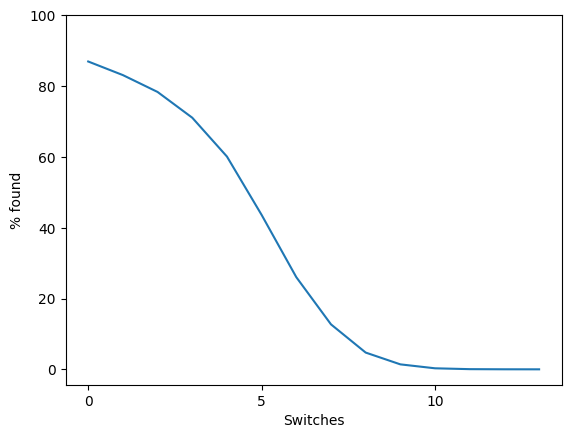

In [8]:
# plot percentage of intervals found vs switch number:
not_found = np.count_nonzero(np.isnan(intervals_true[:,:,0]),axis=(0,1))
counts = np.count_nonzero(~np.isnan(intervals_true),axis=(0,1))
counts = counts[np.nonzero(counts)]
print(r'% found =',str((100*counts)/(TESTS*VMAPS)))
print(r'% not found =',str((100*not_found)/(TESTS*VMAPS)))
fig,ax = plt.subplots()
ax.plot(np.arange(len(counts)),(100*counts)/(TESTS*VMAPS))
ax.set_xticks([0,5,10])
ax.set_xticklabels(['0','5','10'])
ax.set_xlabel('Switches')
ax.set_yticks([0,20,40,60,80,100])
ax.set_yticklabels(['0','20','40','60','80','100'])
ax.set_ylabel('% found')

In [ ]:
# (new) plot intervals vs distance to dot (by considering range of dis then finding mean interval) 
bins = 10
switches = [0,4,8]
dis_bins = np.nan*np.empty((len(switches),bins+1))
int_bins_avg = np.nan*np.empty((len(switches),bins))
int_bins_sd = np.nan*np.empty((len(switches),bins))

for i,s in enumerate(switches):
    max = np.sqrt(2*np.pi**2) #np.nanmax(dis_[:,:,s])
    min = 0 #np.nanmin(dis_[t,v,:])
    dis_bins[i,:] = np.linspace(min,max,bins+1) #[switches,bins+1]
    for b in range(bins):
        dis_locs = (dis_switch[:,:,s]>=dis_bins[i,b])&(dis_switch[:,:,s]<dis_bins[i,b+1]) # indexes [t,v]
        int_bins_avg[i,b] = np.nanmean(intervals_true[:,:,s][dis_locs])
        int_bins_sd[i,b] = np.nanstd(intervals_true[:,:,s][dis_locs])

# plot int_bins_avg vs dis_bins (for each switch)
fig,ax = plt.subplots()
colors = ['darkblue','blue','lightblue']
for i in range(len(switches)):
    # plot sd as error bars:
    ax.plot(dis_bins[i,:-1]+dis_bins[i,1]/2,int_bins_avg[i,:],c=colors[i])
    ax.scatter(dis_bins[i,:-1]+dis_bins[i,1]/2,int_bins_avg[i,:],c=colors[i],label='Switch '+str(switches[i]),s=15)#s+1
    # ax.errorbar(dis_bins[i,:-1]+dis_bins[i,1]/2,int_bins_avg[i,:],yerr=int_bins_sd[i,:]/2,capsize=3,alpha=0.5)
    # ax.fill_between(dis_bins[i,:-1]+dis_bins[i,1]/2,int_bins_avg[i,:]-int_bins_sd[i,:]/4,int_bins_avg[i,:]+int_bins_sd[i,:]/4,alpha=0.5,color='#cdd4d4')
ax.set_xticks([0,np.pi/2,np.pi,3*np.pi/2])
ax.set_xticklabels([r'$0$',r'$\pi/2$',r'$\pi$',r'$3\pi/2$']) # [r'$0$',r'$\sqrt{2}\pi$']
ax.set_xlabel('Distance to reward')
ax.set_yticks([0,20,40])
ax.set_yticklabels(['0','20','40'])
ax.set_ylabel('Steps to reward')
ax.set_title('Steps vs distance to reward')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

path__ = os.path.dirname(os.getcwd()) + '/figs_analysis/'
dt = datetime.now().strftime("%d_%m-%H%M")
plt.savefig(path__ + 'dis_reward_intervals_' + file_ + dt + '.png')

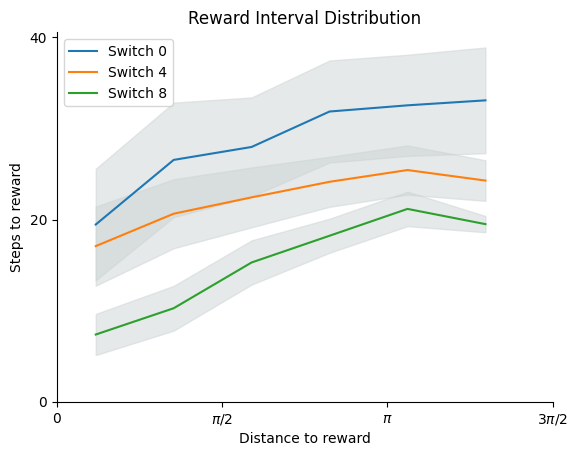

In [6]:
# plot intervals vs distance to dot (by considering range of dis then finding mean interval)
bins = 6
switches = [0,4,8]
dis_bins = np.nan*np.empty((len(switches),bins+1))
int_bins_avg = np.nan*np.empty((len(switches),bins))
int_bins_sd = np.nan*np.empty((len(switches),bins))

for i,s in enumerate(switches):
    max = np.sqrt(2*np.pi**2) #np.nanmax(dis_[:,:,s])
    min = 0 #np.nanmin(dis_[t,v,:])
    dis_bins[i,:] = np.linspace(min,max,bins+1) #[switches,bins+1]
    for b in range(bins):
        dis_locs = (dis_switch[:,:,s]>=dis_bins[i,b])&(dis_switch[:,:,s]<dis_bins[i,b+1]) # indexes [t,v]
        int_bins_avg[i,b] = np.nanmean(intervals_true[:,:,s][dis_locs])
        int_bins_sd[i,b] = np.nanstd(intervals_true[:,:,s][dis_locs])

# plot int_bins_avg vs dis_bins (for each switch)
fig,ax = plt.subplots()
for i in range(len(switches)):
    ax.plot(dis_bins[i,:-1]+dis_bins[i,1]/2,int_bins_avg[i,:],label='Switch '+str(switches[i]))#s+1
    ax.fill_between(dis_bins[i,:-1]+dis_bins[i,1]/2,int_bins_avg[i,:]-int_bins_sd[i,:]/4,int_bins_avg[i,:]+int_bins_sd[i,:]/4,alpha=0.5,color='#cdd4d4')
ax.set_xticks([0,np.pi/2,np.pi,3*np.pi/2])
ax.set_xticklabels([r'$0$',r'$\pi/2$',r'$\pi$',r'$3\pi/2$']) # [r'$0$',r'$\sqrt{2}\pi$']
ax.set_xlabel('Distance to reward')
ax.set_yticks([0,20,40])
ax.set_yticklabels(['0','20','40'])
ax.set_ylabel('Steps to reward')
ax.set_title('Steps vs distance to reward')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

path__ = os.path.dirname(os.getcwd()) + '/figs_analysis/'
dt = datetime.now().strftime("%d_%m-%H%M")
plt.savefig(path__ + 'dis_reward_intervals_' + file_ + '.png')

In [37]:
# # %history
# print(counts)
# print(np.linspace(0,10,5))

[5087 4752 4435 4044 3428 2633 1843 1072  569  241   89   30    6]
[ 0.   2.5  5.   7.5 10. ]


/tmp/ipykernel_23856/1124653593.py:6: RuntimeWarning: invalid value encountered in multiply
  pos_arr_dis_avg = np.nan*np.empty((IT//4,IT))
/tmp/ipykernel_23856/1124653593.py:7: RuntimeWarning: invalid value encountered in multiply
  pos_arr_dis_std = np.nan*np.empty((IT//4,IT))


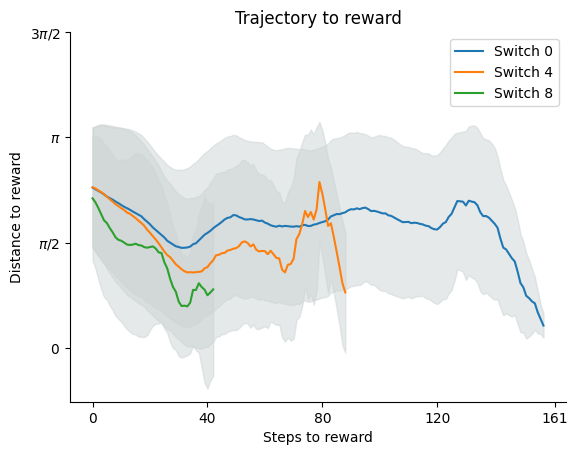

In [41]:
# plot graph of typical trajectory to reward for each switch
# get index ranges based on switch_arr for each switch:
plot_count = [0,4,8]
# pos_arr_traj = np.nan*np.empty((TESTS,VMAPS,IT,2))
pos_arr_dis = np.nan*np.empty((TESTS,VMAPS,IT//4,IT))
pos_arr_dis_avg = np.nan*np.empty((IT//4,IT))
pos_arr_dis_std = np.nan*np.empty((IT//4,IT))
# switch_locs_arr_ = switch_locs_arr.astype(int)
for t in range(TESTS): #TESTS
    for v in range(VMAPS):
        count = np.count_nonzero(~np.isnan(switch_locs_arr[t,v,:]))
        # print('t,v,count=',t,v,count)
        if count>1:
            for c in range(count-1):
                # print(t,v,c,switch_locs_arr[t,v,c],switch_locs_arr[t,v,(c+1)],type(switch_locs_arr[t,v,c]),pos_arr[t,v,switch_locs_arr[t,v,c].astype(int):switch_locs_arr[t,v,(c+1)].astype(int),:].shape)
                # pos_arr_traj[t,v,:(switch_locs_arr[t,v,(c+1)].astype(int)-switch_locs_arr[t,v,c].astype(int)),:] = pos_arr[t,v,switch_locs_arr[t,v,c].astype(int):switch_locs_arr[t,v,(c+1)].astype(int),:]
                pos_arr_dis[t,v,c,:(switch_locs_arr[t,v,(c+1)].astype(int)-switch_locs_arr[t,v,c].astype(int))] = dis_all[t,v,switch_locs_arr[t,v,c].astype(int):switch_locs_arr[t,v,(c+1)].astype(int)]
            
                # switch = switch_locs_arr[t,v,c]
                # pos_arr_traj[t,v,c,:] = pos_arr[t,v,switch,:]
                # pos_arr_dis[t,v,c] = dis_[t,v,switch]

for c in range(IT//4):
    for i in range(IT):
        t = np.count_nonzero(~np.isnan(pos_arr_dis[:,:,c,i]))
        if t>=5:
            pos_arr_dis_avg[c,i] = np.nanmean(pos_arr_dis[:,:,c,i])
            pos_arr_dis_std[c,i] = np.nanstd(pos_arr_dis[:,:,c,i])
    # pos_arr_dis_avg[c,:] = np.nanmean(pos_arr_dis[:,:,c,:],axis=(0,1))
    # # print('example 0:',pos_arr_dis[0,0,:],'example 1:',pos_arr_dis[0,1,:],'avg:',pos_arr_dis_avg[0,:])
    # pos_arr_dis_std[c,:] = np.nanstd(pos_arr_dis[:,:,c,:],axis=(0,1))

# plot average trajectory to reward for each switch, with std:
fig,ax = plt.subplots()
for c in plot_count:
    ax.plot(pos_arr_dis_avg[c,:],label='Switch '+str(c))
    ax.fill_between(np.arange(IT),pos_arr_dis_avg[c,:]-pos_arr_dis_std[c,:],pos_arr_dis_avg[c,:]+pos_arr_dis_std[c,:],alpha=0.5,color='#cdd4d4')
ax.set_xticks([0,IT//4,IT//2,3*IT//4,IT])
ax.set_xticklabels([0,IT//4,IT//2,3*IT//4,IT])
ax.set_xlabel('Steps to reward')
ax.set_yticks([0,np.pi/2,np.pi,3*np.pi/2])
ax.set_yticklabels([r'$0$',r'$\pi/2$',r'$\pi$',r'$3\pi/2$']) # [r'$0$',r'$\sqrt{2}\pi$']
ax.set_ylabel('Distance to reward')
ax.set_title('Trajectory to reward')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
# fig,ax = plt.subplots()
# for s in range(11):
#     ax.plot(np.arange(VMAPS),intervals_true[0,:,s],label='Switch '+str(s))
# ax.set_xticks([0,5,10])# plot graph of typical trajectory to reward for each switch


[[2.41521971 2.39227099 2.37367091 ...        nan        nan        nan]
 [2.4149743  2.39209076 2.37347423 ...        nan        nan        nan]
 [2.41410532 2.39103514 2.37252112 ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]
[[0.91660996 0.95892637 0.99836414 ...        nan        nan        nan]
 [0.91626381 0.95866904 0.99810516 ...        nan        nan        nan]
 [0.91551796 0.95777973 0.99734869 ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


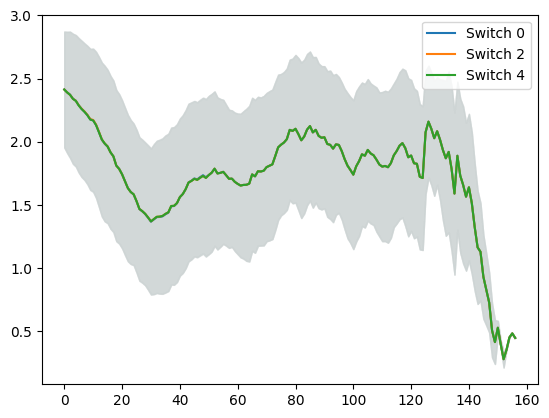

In [26]:
print(pos_arr_dis_avg)
print(pos_arr_dis_std)
fig,ax = plt.subplots()
plot_count = [0,2,4]
for c in plot_count:
    ax.plot(pos_arr_dis_avg[c,:],label='Switch '+str(c))
    ax.fill_between(np.arange(IT),pos_arr_dis_avg[c,:]-pos_arr_dis_std[c,:]/2,pos_arr_dis_avg[c,:]+pos_arr_dis_std[c,:]/2,alpha=0.5,color='#cdd4d4')
ax.legend()

In [ ]:
#(replot training)
ki = rnd.split(rnd.PRNGKey(0), 30)
plt.figure()
# title__ = f'v9 training, tot epochs={TOT_EPOCHS}, it={IT}, vmaps={VMAPS}, init={INIT:.2f}, update={UPDATE:.5f}, SIGMA_A={SIGMA_A:.1f}, SIGMA_R0={SIGMA_R0:.1f}, SIGMA_RINF={SIGMA_RINF:.1f}, \n SIGMA_N={SIGMA_N:.1f}, STEP={STEP:.3f} WD={WD:.5f}, LAMBDA_D={LAMBDA_D:.4f}, LAMBDA_E={LAMBDA_E:.4f}, LAMBDA_S={LAMBDA_S:.4f}, NEURONS={NEURONS}' # \n colors={jnp.array_str(COLORS[0][:]) + jnp.array_str(COLORS[1][:]) + jnp.array_str(COLORS[2][:])}' #  + jnp.array_str(COLORS[3][:]) + jnp.array_str(COLORS[4][:])}'
fig,ax = plt.subplots(2,3,figsize=(16,9))
# plt.suptitle(title__,fontsize=14)
plt.subplot(2,3,1)
plt.errorbar(jnp.arange(len(R_tot)),R_tot,yerr=sd_tot/2,ecolor="black",elinewidth=0.5,capsize=1.5)
plt.ylabel(r'$R_{tot}$',fontsize=15)
plt.xlabel(r'Iteration',fontsize=12)
plt.subplot(2,3,2)
plt.errorbar(jnp.arange(len(R_obj)),R_obj,yerr=sd_obj/2,ecolor="black",elinewidth=0.5,capsize=1.5)
plt.ylabel(r'$R_{obj}$',fontsize=15)
plt.xlabel(r'Iteration',fontsize=12)
plt.subplot(2,3,3)
plt.errorbar(jnp.arange(len(R_env)),R_env,yerr=sd_env/2,ecolor="black",elinewidth=0.5,capsize=1.5)
plt.ylabel(r'$R_{env}$',fontsize=15)
plt.xlabel(r'Iteration',fontsize=12)
plt.subplot(2,3,4)
plt.errorbar(jnp.arange(len(R_dot)),R_dot,yerr=sd_dot/2,ecolor="black",elinewidth=0.5,capsize=1.5)
plt.ylabel(r'$R_{dot}$',fontsize=15)
plt.xlabel(r'Iteration',fontsize=12)
plt.subplot(2,3,5)
plt.errorbar(jnp.arange(len(R_sel)),R_sel,yerr=sd_sel/2,ecolor="black",elinewidth=0.5,capsize=1.5)
plt.ylabel(r'$R_{sel}$',fontsize=15)
plt.xlabel(r'Iteration',fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
#(replot testing)
geod_dist_vmap = jax.vmap(geod_dist,in_axes=(None,0),out_axes=0)# (e_t,pos_t)
colors_ = np.float32([[255,0,0],[0,255,0],[0,0,255]])/255 #theta_0["ENV"]["COLORS"]/255
colormap = cm.seismic(np.linspace(0,1,IT+1), alpha=1)

plt.figure()
# title__ = f'v9 testing, tot epochs={TOT_EPOCHS}, it={IT}, vmaps={VMAPS}, init={INIT:.2f}, update={UPDATE:.5f}, SIGMA_N={SIGMA_N}, SIGMA_A={SIGMA_A:.1f}, SIGMA_R0={SIGMA_R0:.1f}, SIGMA_RINF={SIGMA_RINF:.1f}, \n SIGMA_N={SIGMA_N:.1f}, STEP={STEP:.3f} WD={WD:.5f}, LAMBDA_D={LAMBDA_D:.4f}, LAMBDA_E={LAMBDA_E:.4f}, LAMBDA_S={LAMBDA_S:.4f}, NEURONS={NEURONS}'
fig,axis = plt.subplots(2*TESTS,4,figsize=(15,5*TESTS+2))#(4,5)
# plt.suptitle(title__,fontsize=14)
for i in range(TESTS):
    k = rnd.randint(ki[18+i],(),0,VMAPS) # rnd.choice(ki[18+j],loop_params["VMAPS"],replace=False)
    ax0 = plt.subplot2grid((2*TESTS,4),(2*i,2),colspan=2)
    ax0.set_ylabel(r'$dis$',fontsize=16)
    # dis_old = dis_arr[i,k,:,:] # [TESTS,VMAPS,IT,3]
    ax0.tick_params(axis='both', which='major', labelsize=14)
    ax0.set_ylim(-0.2,jnp.pi+0.2) # 2*jnp.pi*jnp.sqrt(2)

    ax1 = plt.subplot2grid((2*TESTS,4),(2*i,0),rowspan=2,colspan=2)
    pos_ = pos_arr[i,k,:,:] # [TESTS,VMAPS,IT,2]
    ax1.scatter(pos_[:,0],pos_[:,1],s=30,color=colormap,marker='.')# axis[i,1]

    sel_ = theta_test["ENV"]["SELECT"][i,k,:] # [EPOCHS,VMAPS,3]
    dots_ = theta_test["ENV"]["DOTS"][i,:,:,k] # [EPOCHS,3,2,VMAPS]
    dis_ = geod_dist_vmap(dots_,pos_)
    ax2 = plt.subplot2grid((2*TESTS,4),(2*i+1,2),colspan=2)
    ax2.plot(R_test[i,k,1:],color='k',linewidth=2) #axis[i,2]
    ax2.set_ylabel(r'$R_{tot}$',fontsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax2.set_ylim(-1.1,0.1) # -1.1,0 -jnp.sqrt(2*jnp.pi)*
    for j in range(theta_test["ENV"]["N_DOTS"]):
        ax0.plot(dis_[1:,j],color=(colors_[j,:]),linewidth=3)#axis[i,0], tuple
        ax0.plot(dis_[1:,j],color=(colors_[j,:]),alpha=0.5,linewidth=1)
        ax1.scatter(dots_[j,0],dots_[j,1],s=60,marker='x',color=(colors_[j,:]))

    ax1.set_xlim(-jnp.pi,jnp.pi)
    ax1.set_ylim(-jnp.pi,jnp.pi)
    ax1.set_xticks([-jnp.pi,-jnp.pi/2,0,jnp.pi/2,jnp.pi])
    ax1.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$'],fontsize=14)
    ax1.set_yticks([-jnp.pi,-jnp.pi/2,0,jnp.pi/2,jnp.pi])
    ax1.set_yticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$'],fontsize=14)
    ax1.set_aspect('equal')
    ax1.set_title(f'sel={sel_}',fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94) 